# Setting up

In [ ]:
# diagnostic: show installed torch/torchvision
import importlib, sys
for pkg in ("torch","torchvision"):
    try:
        m = importlib.import_module(pkg)
        print(pkg, m.__version__)
    except Exception as e:
        print(pkg, "NOT INSTALLED:", e)


torch 2.8.0+cu126
torchvision 0.23.0+cu126


In [ ]:
# move the uploaded kaggle.json into place and set permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# test kaggle config (lists username)
!cat ~/.kaggle/kaggle.json


{"username":"matiworasing","key":"db219db857c0b7af11757d15cd06b32a"}

# Downloading Dataset

In [ ]:
# 1. Install kaggle and other deps
!pip install kaggle --quiet
!pip install torchvision==0.23.0

# 2. Download the dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification -p /content --unzip


Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors
  0% 0.00/82.0M [00:00<?, ?B/s]
100% 82.0M/82.0M [00:00<00:00, 1.70GB/s]


In [ ]:
import os, random, shutil
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import torch, torch.nn as nn, torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
import torch.nn.functional as F
from collections import Counter
from torch.utils.data import WeightedRandomSampler

In [ ]:
# ---------------- Helper: split into train/val/test ----------------
def split_dataset_folder(root_dir: str, val_fraction=0.15, test_fraction=0.15):
    root = Path(root_dir)
    train_dir = root / "train"; val_dir = root / "val"; test_dir = root / "test"
    if train_dir.exists() and val_dir.exists() and test_dir.exists():
        return
    class_dirs = [d for d in root.iterdir() if d.is_dir() and d.name not in {"train","val","test"}]
    for split in ("train","val","test"): (root/split).mkdir(exist_ok=True)
    for class_dir in class_dirs:
        imgs = [p for p in class_dir.iterdir() if p.is_file()]
        random.shuffle(imgs)
        n = len(imgs); n_test = int(n * test_fraction); n_val = int(n * val_fraction); n_train = n - n_val - n_test
        targets = [(root/"train"/class_dir.name),(root/"val"/class_dir.name),(root/"test"/class_dir.name)]
        for td in targets: td.mkdir(parents=True, exist_ok=True)
        for i, src in enumerate(imgs):
            if i < n_train: dst = targets[0]/src.name
            elif i < n_train + n_val: dst = targets[1]/src.name
            else: dst = targets[2]/src.name
            if not dst.exists():
                shutil.copy(src, dst)

In [ ]:
# ---------------- Config ----------------
DATA_DIR = "/content/Garbage classification/Garbage classification"   # actual unzipped path
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NUM_CLASSES = 6
BATCH_SIZE = 32
IMAGE_SIZE = 224  #224 if ไหว
LR = 1e-3
EPOCHS = 45
MODEL_SAVE_PATH = "/content/best_trash_cnn.pth"
SEED = 42

random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
if torch.cuda.is_available(): torch.cuda.manual_seed_all(SEED)

In [ ]:
# create splits if not present
split_dataset_folder(DATA_DIR)

In [ ]:
# ---------------- Transforms & loaders ----------------
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMAGE_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.25, contrast=0.25, saturation=0.15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

val_test_transforms = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.10)),
    transforms.CenterCrop(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

train_ds = ImageFolder(os.path.join(DATA_DIR, "train"), transform=train_transforms)
val_ds   = ImageFolder(os.path.join(DATA_DIR, "val"),   transform=val_test_transforms)
test_ds  = ImageFolder(os.path.join(DATA_DIR, "test"),  transform=val_test_transforms)

print("Classes:", train_ds.classes)
assert len(train_ds.classes) == NUM_CLASSES, f"expected {NUM_CLASSES} classes, found {len(train_ds.classes)}"

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

Classes: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


In [ ]:
# ---------------------- CNN Model ----------------------
class ConvBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True),
        )
        self.downsample = None
        if stride != 1 or in_c != out_c:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_c)
            )

    def forward(self, x):
        identity = x
        out = self.conv(x)
        if self.downsample is not None:
            identity = self.downsample(identity)
        out = out + identity
        return F.relu(out)

# lightweight squeeze-and-excite
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channels, channels // reduction),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction, channels),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x).unsqueeze(-1).unsqueeze(-1)
        return x * w

class DeeperTrashCNN(nn.Module):
    def __init__(self, num_classes=6):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2, padding=1)
        )
        self.layer1 = nn.Sequential(ConvBlock(64, 64, stride=1), SEBlock(64))
        self.layer2 = nn.Sequential(ConvBlock(64, 128, stride=2), SEBlock(128))
        self.layer3 = nn.Sequential(ConvBlock(128, 256, stride=2), SEBlock(256))
        self.layer4 = nn.Sequential(ConvBlock(256, 512, stride=2), SEBlock(512))

        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.pool(x)
        x = self.classifier(x)
        return x

model = DeeperTrashCNN(num_classes=6).to(DEVICE)

In [ ]:
# ---------------- Loss, optimizer (class weights from training counts) ----------------
counts = Counter([y for _, y in train_ds.samples])
counts_list = [counts[i] for i in range(len(train_ds.classes))]
print("Class counts:", counts_list)
total = sum(counts_list)
weights = [total / (len(counts_list) * c) if c>0 else 1.0 for c in counts_list]
weight_t = torch.tensor(weights, dtype=torch.float).to(DEVICE)

criterion = nn.CrossEntropyLoss(weight=weight_t)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

Class counts: [283, 351, 288, 416, 338, 97]


In [ ]:
#check ว่า model ตอนนี้ถูกตัวมั้ย
print(model.__class__.__name__)


DeeperTrashCNN


In [ ]:
# ---------------- Train / Eval loops ----------------
def train_epoch(m, loader, opt, crit):
    m.train()
    running_loss=0; correct=0; total=0
    for imgs, labels in loader:
        imgs=imgs.to(DEVICE); labels=labels.to(DEVICE)
        opt.zero_grad()
        logits = m(imgs)
        loss = crit(logits, labels)
        loss.backward(); opt.step()
        running_loss += loss.item() * imgs.size(0)
        preds = logits.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    return running_loss/total, correct/total

def evaluate(m, loader, crit):
    m.eval()
    running_loss=0; correct=0; total=0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs=imgs.to(DEVICE); labels=labels.to(DEVICE)
            logits = m(imgs)
            loss = crit(logits, labels)
            running_loss += loss.item() * imgs.size(0)
            preds = logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return running_loss/total, correct/total

best_val = float("inf")
history = {"train_loss":[],"train_acc":[],"val_loss":[],"val_acc":[]}

for ep in range(1, EPOCHS+1):
    tr_loss, tr_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)
    scheduler.step(val_loss)
    history["train_loss"].append(tr_loss); history["train_acc"].append(tr_acc)
    history["val_loss"].append(val_loss); history["val_acc"].append(val_acc)
    print(f"Epoch {ep}: train loss {tr_loss:.4f}, acc {tr_acc:.4f} | val loss {val_loss:.4f}, acc {val_acc:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save({"epoch":ep,"model":model.state_dict(),"classes":train_ds.classes}, MODEL_SAVE_PATH)
        print("Saved best model.")

Epoch 1: train loss 1.5461, acc 0.3514 | val loss 1.4997, acc 0.4350
Saved best model.
Epoch 2: train loss 1.4159, acc 0.4264 | val loss 1.2927, acc 0.4987
Saved best model.
Epoch 3: train loss 1.3871, acc 0.4337 | val loss 1.4908, acc 0.3581
Epoch 4: train loss 1.3317, acc 0.4766 | val loss 1.3102, acc 0.5172
Epoch 5: train loss 1.3145, acc 0.4715 | val loss 1.2171, acc 0.4987
Saved best model.
Epoch 6: train loss 1.2877, acc 0.4766 | val loss 1.2074, acc 0.5279
Saved best model.
Epoch 7: train loss 1.2735, acc 0.4935 | val loss 1.1522, acc 0.5464
Saved best model.
Epoch 8: train loss 1.2910, acc 0.4924 | val loss 1.2396, acc 0.5252
Epoch 9: train loss 1.2112, acc 0.5076 | val loss 1.1671, acc 0.5517
Epoch 10: train loss 1.2290, acc 0.5245 | val loss 1.1364, acc 0.5782
Saved best model.
Epoch 11: train loss 1.1994, acc 0.5426 | val loss 1.1509, acc 0.5597
Epoch 12: train loss 1.1798, acc 0.5561 | val loss 1.0916, acc 0.5862
Saved best model.
Epoch 13: train loss 1.1791, acc 0.5358 | v

Test loss: 0.6194179570327071 Test acc: 0.7718832891246684
Confusion matrix:
[[50  0  2  3  2  3]
 [ 0 62  4  0  6  3]
 [ 1  5 49  1  5  0]
 [ 4  2  5 68  3  7]
 [ 2  7  3  8 46  6]
 [ 0  1  1  2  0 16]]
              precision    recall  f1-score   support

   cardboard       0.88      0.83      0.85        60
       glass       0.81      0.83      0.82        75
       metal       0.77      0.80      0.78        61
       paper       0.83      0.76      0.80        89
     plastic       0.74      0.64      0.69        72
       trash       0.46      0.80      0.58        20

    accuracy                           0.77       377
   macro avg       0.75      0.78      0.75       377
weighted avg       0.79      0.77      0.77       377



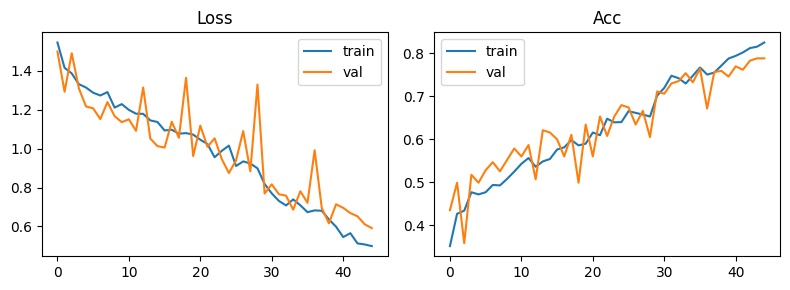

In [ ]:
# ---------------- Final test ----------------
ckpt = torch.load(MODEL_SAVE_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])
test_loss, test_acc = evaluate(model, test_loader, criterion)
print("Test loss:", test_loss, "Test acc:", test_acc)

# Optional: confusion matrix / classification report (scikit-learn required)
try:
    from sklearn.metrics import confusion_matrix, classification_report
    import numpy as np
    all_preds=[]; all_labels=[]
    model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs=imgs.to(DEVICE)
            logits = model(imgs)
            preds = logits.argmax(dim=1).cpu().numpy()
            all_preds.append(preds); all_labels.append(labels.numpy())
    all_preds = np.concatenate(all_preds); all_labels = np.concatenate(all_labels)
    print("Confusion matrix:")
    print(confusion_matrix(all_labels, all_preds))
    print(classification_report(all_labels, all_preds, target_names=train_ds.classes))
except Exception as e:
    print("sklearn not installed or other error:", e)

# Plot train curves
plt.figure(figsize=(8,3))
plt.subplot(1,2,1); plt.plot(history["train_loss"], label="train"); plt.plot(history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history["train_acc"], label="train"); plt.plot(history["val_acc"], label="val"); plt.title("Acc"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
#แสดงตัวอย่างผลลัพท์

# ชื่อคลาส (ให้ตรงกับ dataset ของคุณ)
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

# ดึงข้อมูลจาก test dataset
test_dataset = test_loader.dataset

# สุ่มภาพจาก test set จำนวน 8 ภาพ
indices = random.sample(range(len(test_dataset)), 8)
images = torch.stack([test_dataset[i][0] for i in indices])
labels = torch.tensor([test_dataset[i][1] for i in indices])
images, labels = images.to(DEVICE), labels.to(DEVICE)

# ทำนายผลลัพธ์จากโมเดล
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Unnormalize (กลับค่าสีให้แสดงถูก)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# แสดงผลภาพ
plt.figure(figsize=(12, 6))
for i in range(8):
    img = images[i].cpu().numpy().transpose((1, 2, 0))
    img = std * img + mean  # unnormalize
    img = np.clip(img, 0, 1)

    plt.subplot(2, 4, i + 1)
    plt.imshow(img)
    pred_label = classes[preds[i].item()]
    true_label = classes[labels[i].item()]
    color = "green" if preds[i] == labels[i] else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color, fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()